# Step 3

# Apply voice activity detection (VAD)

# Voice Activity Detection (VAD) aims to distinguish correctly those audio segments containing human speech

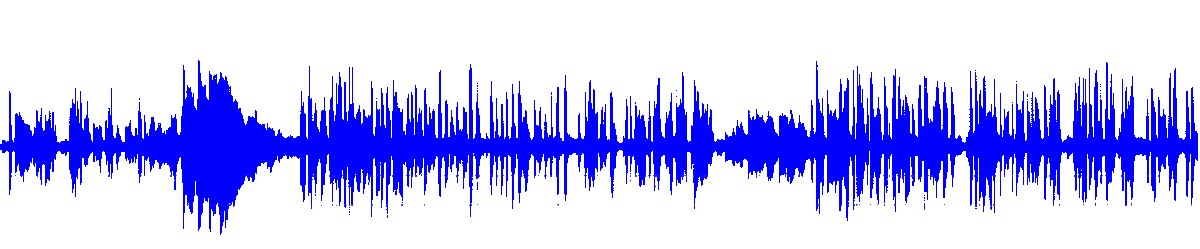

However, in our case, after detection voice sections, we must find glottal activity as well

In [10]:
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
overlap = 1024
frame_length = 2048

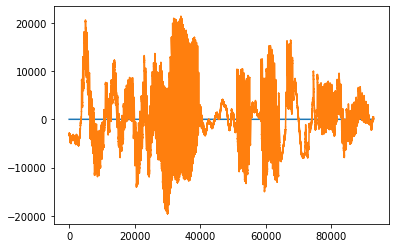

In [11]:
from vad import VoiceActivityDetector

filename = '4-phrase-egg.wav'
v = VoiceActivityDetector(filename)
v.plot_detected_speech_regions()

In [12]:
from scipy.io import wavfile

def readAudio(audio):
    fs, amp = wavfile.read(audio)
    dt = 1/fs
    n = len(amp)
    t = dt*n

    if t > 1.0:
        amp = amp[int((t/2 - 0.5)/dt):int((t/2 + 0.5)/dt)]
        n = len(amp)
        t = dt*n
    
    return(amp, fs, n, t)

Text(0.5, 1.0, 'signal')

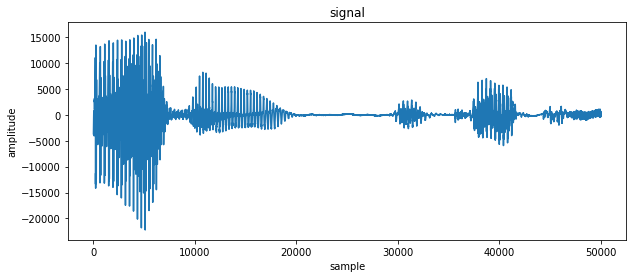

In [13]:
#amp, fs, n ,t = readAudio('./data/male_healthy/1032-a_n.wav')
amp, fs, n ,t = readAudio('4-phrase.wav')


fig = plt.figure(figsize=(10,4))

plt.plot(amp)
plt.ylabel('amplitude')
plt.xlabel('sample')
plt.title('signal')

# finding GCI using Deep learning network

In [45]:
def get_gci_triangle(targetPred, sr, thresh=0.5):
    '''
    Detect GCI positions using peak-picking on predicted triangle target curve
    :param targetPred: predicted triangle target curve
    :param sr: samling rate of predicted target curve (should be 16kHz)
    :return: positions of detected GCIs, in s
    '''
    fmax = 1000.
    minPeriodSamples = int(sr / fmax)

    prominence = 0.25 * thresh
    width = int(minPeriodSamples / 4)
    (peaks_pos, peaks_properties) = find_peaks(targetPred, height=thresh, distance=minPeriodSamples, prominence=prominence, width=width)
    GCI_times = peaks_pos / sr

    return GCI_times


def filter_peaks_for_no_sign_change_in_dgf_between_peaks(peaks, dgf, posDgfThresh = 0.005):
    '''

    :param peaks:
    :param dgf:
    :param posDgfThresh:
    :return:
    '''
    group = []
    peakGroups = []
    group.append(peaks[0])
    for i,p in enumerate(peaks[1:]):
        i += 1
        dgf_seg = dgf[peaks[i-1]:p]
        if(np.max(dgf_seg)<posDgfThresh):
            group.append(p)
        else:
            peakGroups.append(group)
            group = [p]

        if(i==len(peaks[1:])):
            peakGroups.append(group)

        filtered_peaks = []

    for g in peakGroups:
        filtered_peaks.append(int(np.round(np.mean(g))))

    return np.array(filtered_peaks)


def get_gci_GF(targetPred, sr, PLOT=False):
    '''
    Detect GCI positions using peak-picking on the negative derivative of the predicted glottal flow target curve
    :param targetPred: predicted glottal flow target curve
    :param sr: samling rate of predicted target curve (should be 16kHz)
    :param PLOT: plot glottal flow and derivative along with detected GCIs
    :return: positions of detected GCIs, in s
    '''

    maxF0 = 500.
    # margin_fact = 0.9
    margin_fact = 1.
    min_period_sec = margin_fact * (1 / maxF0)

    minGFHeightAtGCI = 0.2

    dgf = np.diff(targetPred)

    distance_samp = int(np.floor(min_period_sec * sr))
    minPeaksWidth = int(round((sr / maxF0) / 8.))
    peaks_res = find_peaks(-1 * dgf * (targetPred[:-1] > minGFHeightAtGCI), height=0.01, distance=distance_samp, width=minPeaksWidth)[0]

    peaks_res = filter_peaks_for_no_sign_change_in_dgf_between_peaks(peaks_res, dgf)

    if (PLOT):
        plt.figure()
        plt.plot(targetPred, 'g')
        plt.plot(dgf, 'r')
        plt.plot(dgf * (targetPred[:-1] > minGFHeightAtGCI), 'b')
        plt.plot(peaks_res, dgf[peaks_res], 'xk')
        plt.show()

    sndTimes = np.arange(len(dgf)) / sr
    GCI_times = sndTimes[peaks_res]

    return GCI_times


def get_gci_times(targetPred, sr, mode='GF', thresh=0.5):

    if(mode=='triangle'):
        GCI_times = get_gci_triangle(targetPred, sr, thresh=thresh)

    elif(mode=='GF'):
        GCI_times = get_gci_GF(targetPred, sr)

    return GCI_times


In [58]:
import os
import sys
try:
    from pysndfile import sndio
except:
    from scipy.io import wavfile
from models.core import load_model
import re
from target_to_GCI import get_gci_times
try:
    from fileio.sdif import mrk # ircam's library for our own use, not available from github
except:
    from file_utils.fileio import write_csv_file
from predict_target import speech_to_target
import numpy as np

In [63]:
import os
import sys
try:
    from pysndfile import sndio
except:
    from scipy.io import wavfile
from models.core import load_model
import re
from target_to_GCI import get_gci_times
try:
    from fileio.sdif import mrk # ircam's library for our own use, not available from github
except:
    from file_utils.fileio import write_csv_file
from predict_target import speech_to_target
import numpy as np


# model is trained for a sampling rate of 16000Hz
model_sr = 16000.


def run_prediction(filename, output = None, modelTag = 'FCN_synth_tri', verbose = True):
    '''
    Collect the sound files to process and run the prediction on each file
    :param filename: List
        List containing paths to sound files (wav or aiff) or folders containing sound files to be analyzed.
    :param output: str or None
        Path to directory for saving output files. If None, output files will be saved to the directory containing the input file.
    :param modelTag: str
        name of the pre-trained model to be used for inference
    :param verbose: bool
        Print status messages and keras progress (default=True).
    :return: nothing
    '''

    # load model:
    load_from_json = False

    if(load_from_json):
        model = load_model(modelTag, from_json=True)
    else:
        model = load_model(modelTag)

    if(modelTag=='FCN_synth_GF'):
        mode = 'GF'
    else:
        mode = 'triangle'

    files = []
    for path in filename:
        if os.path.isdir(path):
            found = ([file for file in os.listdir(path) if
                      (file.lower().endswith('.wav') or file.lower().endswith('.aiff') or file.lower().endswith('.aif'))])
            if len(found) == 0:
                print('FCN_GCI: No sound files (only wav or aiff supported) found in directory {}'.format(path),
                      file=sys.stderr)
            files += [os.path.join(path, file) for file in found]
        elif os.path.isfile(path):
            if not (path.lower().endswith('.wav') or path.lower().endswith('.aiff') or path.lower().endswith('.aif')):
                print('FCN_GCI: Expecting sound file(s) (only wav or aiff supported) but got {}'.format(path),
                      file=sys.stderr)
            else:
                files.append(path)
        else:
            print('FCN_GCI: File or directory not found: {}'.format(path),
                  file=sys.stderr)

    if len(files) == 0:
        print('FCN_GCI: No sound files found in {} (only wav or aiff supported), aborting.'.format(filename))
        sys.exit(-1)

    for i, file in enumerate(files):
        if verbose:
            print('FCN_GCI: Processing {} ... ({}/{})'.format(
                file, i+1, len(files)), file=sys.stderr)
        run_prediction_on_file(file, output=output, model=model, mode=mode, verbose=verbose)
    return


def get_output_path(file, suffix, output_dir):
    '''
    Return the path of an output file corresponding to a wav file
    :param file: input file
    :param suffix: suffixe to be used for the output file
    :param output_dir: output directory where to store output file
    :return: full path of output file
    '''

    if((output_dir is not None) and ((suffix.endswith('.sdif') and output_dir.endswith('sdif')) or (suffix.endswith('.csv') and output_dir.endswith('csv')))):
        path = output_dir
    else:
        (filePath, ext) = os.path.splitext(file)
        path = re.sub(r"(?i)"+ext+"$", suffix, file)
        if output_dir is not None:
            path = os.path.join(output_dir, os.path.basename(path))
            if(not os.path.isdir(output_dir)):
                os.makedirs(output_dir)
    return path


def run_prediction_on_file(inFile, output=None, model=None, mode = 'GF', maxSndSegLenSec = 60, model_input_size = 993, totalNetworkPoolingFactor = 8, verbose=True):
    '''
    Run the prediction of target waveform on input file
    :param file: full path to the file to be analyzed
    :param output: output directory
    :param model: prebuilt model with preloaded weights to be used for inference
    :param maxSndSegLenSec: default is 60s. Analyse segments of a maximum duration of maxSndSegLenSec seconds to avoid running out of memory
    :param verbose: print some infos
    :return: don't return anything
    '''

    if(model==None):
        raise('FCN_GCI: model is None')

    targetPred = speech_to_target(inFile, model, model_input_size=model_input_size, maxSndSegLenSec=maxSndSegLenSec, totalNetworkPoolingFactor=totalNetworkPoolingFactor, verbose=verbose, model_sr=model_sr)

    targetFile = get_output_path(inFile, ".targetPred.wav", output)
    outputDir = os.path.dirname(targetFile)
    if(not os.path.isdir(outputDir)):
        os.makedirs(outputDir)
    print("saving target shape analysis to file "+targetFile)
    try:
        sndio.write(targetFile, targetPred, model_sr, 'wav', 'pcm16')
    except:
        wavfile.write(targetFile, int(model_sr), targetPred)

    GCI_times = get_gci_times(targetPred, model_sr, mode=mode)

    try:
        GCIFile = targetFile.replace('.targetPred.wav', '.GCI.sdif')
        mrk.store(GCIFile, GCI_times, ['GCI'] * len(GCI_times))
        print("saved GCI markers in file "+GCIFile)
    except:
        GCIFile = targetFile.replace('.targetPred.wav', '.GCI.csv')
        write_csv_file(GCIFile, GCI_times, ['GCI'] * len(GCI_times))
        print("saved GCI markers in file "+GCIFile)

    return

In [65]:
inputFile ='4-phrase.wav'
outputFile = '' # current directory
output= None
mode = 'GF' # mode for GCI detection from target curve, either triangle or GF (as the process is different depending on the type of target curve predicted by the model)'
thresh =  0.5 # peak heights threshold for determining GCIs positions from predicted target curve
modelTag ='FCN_synth_GF' # name model to be used for prediction (default is FCN_synth_GF)'

In [77]:
input = '4-phrase.wav'

In [66]:
(sr, targetPred) = wavfile.read(inputFile)

In [67]:
from scipy.signal import find_peaks

In [68]:
# model is trained for a sampling rate of 16000Hz
model_sr = 16000.

In [69]:
GCI_times = get_gci_times(targetPred, sr, mode=mode, thresh=thresh)

In [78]:
run_prediction(input, output=output, modelTag=modelTag, verbose=True)

True


FCN_GCI: File or directory not found: 4
FCN_GCI: File or directory not found: -
FCN_GCI: File or directory not found: p
FCN_GCI: File or directory not found: h
FCN_GCI: File or directory not found: r
FCN_GCI: File or directory not found: a
FCN_GCI: File or directory not found: s
FCN_GCI: File or directory not found: e
FCN_GCI: File or directory not found: w
FCN_GCI: File or directory not found: a
FCN_GCI: File or directory not found: v
FCN_GCI: Processing .\1-a_h-egg.wav ... (1/6)


duration of sound is 1.99352
1/1 [==============================] - 1s 638ms/step
saving target shape analysis to file .\1-a_h-egg.targetPred.wav
saved GCI markers in file .\1-a_h-egg.GCI.csv


FCN_GCI: Processing .\4-phrase-egg.wav ... (2/6)


duration of sound is 1.85708
1/1 [==============================] - 0s 476ms/step
saving target shape analysis to file .\4-phrase-egg.targetPred.wav
saved GCI markers in file .\4-phrase-egg.GCI.csv


FCN_GCI: Processing .\4-phrase.wav ... (3/6)


duration of sound is 1.85708
1/1 [==============================] - 0s 486ms/step
saving target shape analysis to file .\4-phrase.targetPred.wav
saved GCI markers in file .\4-phrase.GCI.csv


FCN_GCI: Processing .\Filtered.wav ... (4/6)


duration of sound is 1.133764172335601
1/1 [==============================] - 0s 308ms/step
saving target shape analysis to file .\Filtered.targetPred.wav
saved GCI markers in file .\Filtered.GCI.csv


FCN_GCI: Processing .\Filtered_ChebbyChev.wav ... (5/6)


duration of sound is 0.99998
1/1 [==============================] - 0s 282ms/step
saving target shape analysis to file .\Filtered_ChebbyChev.targetPred.wav
saved GCI markers in file .\Filtered_ChebbyChev.GCI.csv


FCN_GCI: Processing .\Filtered_NoiseReduced.wav ... (6/6)


duration of sound is 0.99998
1/1 [==============================] - 0s 278ms/step
saving target shape analysis to file .\Filtered_NoiseReduced.targetPred.wav
saved GCI markers in file .\Filtered_NoiseReduced.GCI.csv


# it has stored the GCI points in .csv files 

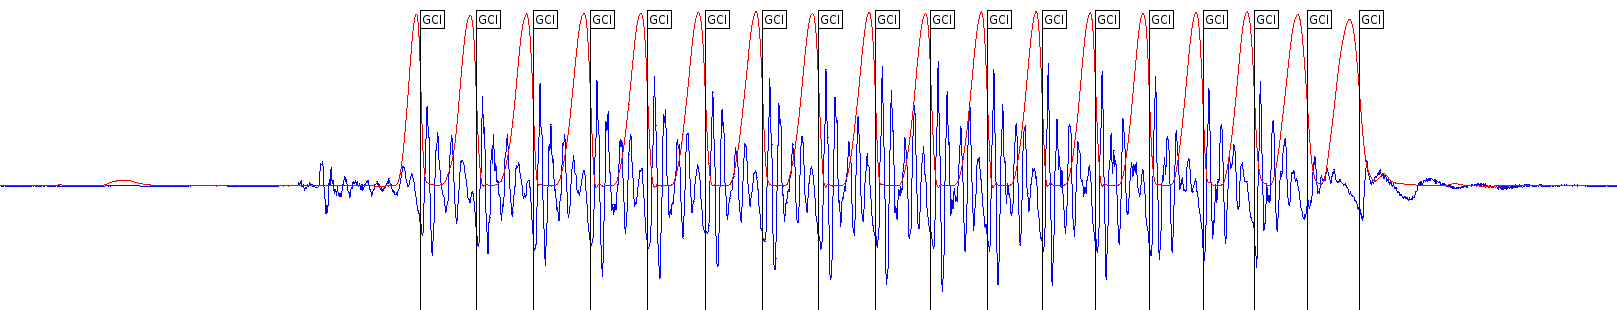

In [7]:
import IPython

IPython.display.Audio("4-phrase-egg.wav")

# Average/Maximum Amplitude Comparison of Frames

In [35]:
import librosa

y, sr = librosa.load('4-phrase-egg.wav')

In [38]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

[Text(0.5, 1.0, 'log Power spectrogram')]

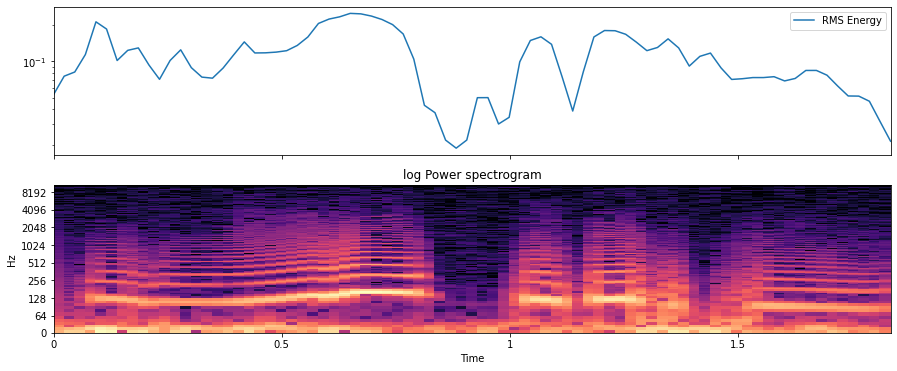

In [39]:
# Plot the RMS energy
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

Zero crossing rate: 486


Text(0.5, 1.0, 'Zoom the how many times it crosses zero values')

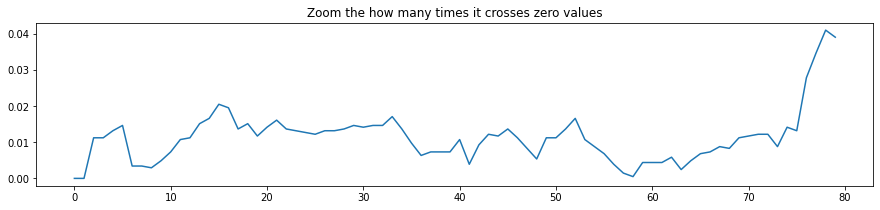

In [42]:

zcrs = librosa.feature.zero_crossing_rate(y)
print(f"Zero crossing rate: {sum(librosa.zero_crossings(y))}")
plt.figure(figsize=(15, 3))
plt.plot(zcrs[0])
plt.title('Zoom the how many times it crosses zero values')

In [36]:
def amplitude_envelope(signal,frame_length,hop_length):
    max_amplitude_frame=[]
    for i in range(0,len(signal),hop_length):
           max_amplitude_frame.append(max(signal[i:i+frame_length]))
    return np.array(max_amplitude_frame)

In [ ]:
librosa.feature,zero_crossing_rate(signal,frame_length, hop_length)
